In [115]:
import pylab as pl
import pandas as pd
import geopandas as gp
import numpy as np
import scipy.stats
import os
import json
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
#lowercase ols
import statsmodels.formula.api as smf
#uppercase OLS
import datetime as dt
import collections
import operator

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Task 1: Event Detection

In [3]:
os.system(os.getenv("PUIDATA")+"/MTA_Fare.npy")

32256

In [4]:
mtaRides = np.load(os.getenv("PUIDATA")+"/MTA_Fare.npy")
#calling data uploaded into PUIDATA

In [5]:
mtaRides.shape #shape of the 3D array

(600, 23, 194)

In [6]:
mtaRides.flatten().shape #flatten test

(2677200,)

In [8]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [9]:
ridetype.shape

(23,)

In [10]:
np.nansum(mtaRides) #nansum before converting -1 to NaN

5776932312

In [11]:
mtaRides = mtaRides.astype('float')
mtaRides[mtaRides == -1] = np.nan
# converting all -1 to NaN

In [12]:
np.nansum(mtaRides) #nansum after converting -1 to nan

5777581875.0

In [13]:
print (mtaRides.shape)

mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)

mta_allsum2 = np.nansum(mtaRides, axis=1)
print (mta_allsum2.shape)

mta_allsum3 = np.array(mta_allsum).reshape(194,23)
print(mta_allsum3.shape)

#600 stations
#23 card types
#194 weeks
#Here I am testing the shape of arrays, collapsing different sides

(600, 23, 194)
(23, 194)
(600, 194)
(194, 23)


In [14]:
ridesbyweek = np.nansum(mta_allsum, axis=0)
ridesbyweek.shape

(194,)

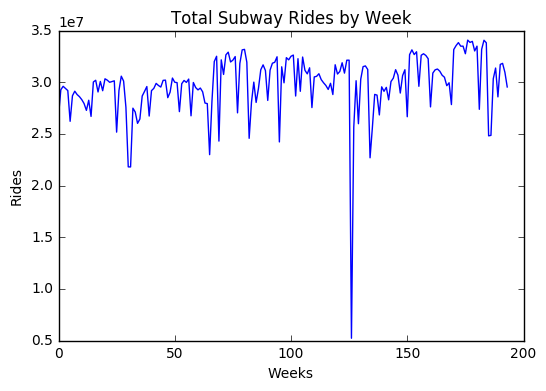

In [72]:
pl.plot(ridesbyweek)
pl.xlabel('Weeks')
pl.ylabel('Rides')
pl.title('Total Subway Rides by Week')
pl.show()

## Figure 1:
The above plot shows the sum of all subway rides, by week, over a period of 194 weeks from 5/21/10 through 2/21/14.

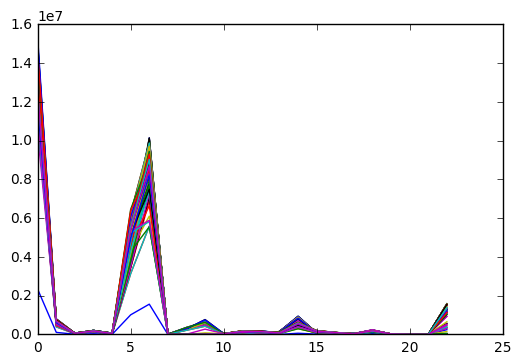

In [73]:
pl.plot(mta_allsum)
pl.show()

#testing a plot for another array

In [17]:
np.nanmean(ridesbyweek)

29781349.87113402

In [18]:
np.nansum(ridesbyweek)

5777581875.0

In [19]:
np.nanstd(ridesbyweek, axis=0)

2983960.421700886

In [20]:
print ("mean rides per week {:.2f}".format(np.nanmean(ridesbyweek)))
print ("stdev rides per week {:.2f}".format(np.nanstd(ridesbyweek)))
thresholds = [np.nanmean(ridesbyweek) + 3 * np.nanstd(ridesbyweek), 
              np.nanmean(ridesbyweek) - 3 * np.nanstd(ridesbyweek)]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))
print ("earliest datapoint", min(ridesbyweek))
#calculating the upper and lower thresholds (-3,+3 stdev)

mean rides per week 29781349.87
stdev rides per week 2983960.42
3-sigma thresholds 38733231.14 20829468.61
('earliest datapoint', 5218686.0)


In [75]:
# Finding the the place of the minimum value in the ridesbyweek array
leastrides = np.where(ridesbyweek==ridesbyweek.min())
print leastrides

(array([126]),)


In [25]:
weekinterval = pd.date_range('5/21/2010', periods=194, freq='W')
weekinterval
weekinterval[127]

Timestamp('2012-10-28 00:00:00', offset='W-SUN')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


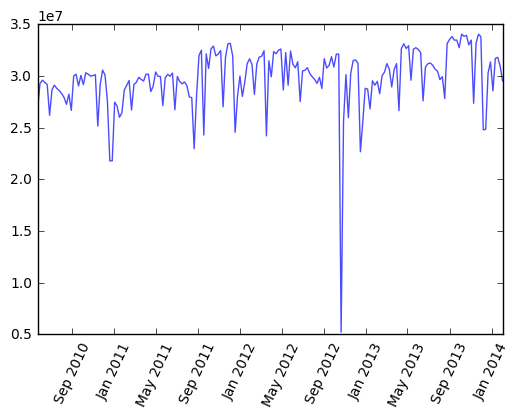

In [26]:
pl.plot(weekinterval,(ridesbyweek),'b', alpha=0.7)
pl.xticks(rotation='65')
pl.legend(loc='upper left')
#plot testing the weekinterval


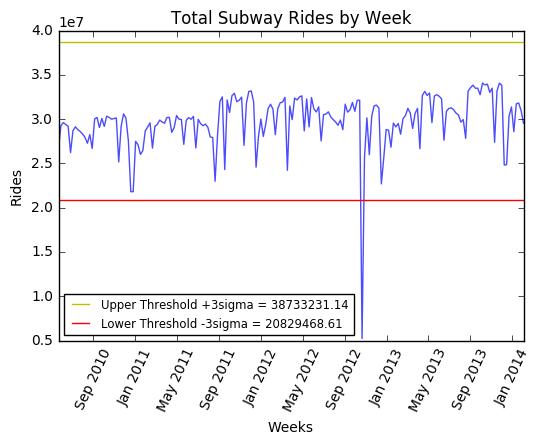

In [76]:
pl.plot(weekinterval,(ridesbyweek),'b', alpha=0.7)
pl.xticks(rotation='65')

pl.plot((min(weekinterval), max(weekinterval)),((thresholds[0]),(thresholds[0])), color='y',
       label='Upper Threshold +3sigma = %.2f' % (thresholds[0]))
pl.plot((min(weekinterval), max(weekinterval)),((thresholds[1]),(thresholds[1])), color='r',
       label='Lower Threshold -3sigma = %.2f' % (thresholds[1]))

pl.xlabel('Weeks')
pl.ylabel('Rides')
pl.title('Total Subway Rides by Week')
pl.legend(loc='best', fontsize='small')

## Figure 2:
The above plot displays total subway rides by week for 194 weeks. The plot includes identifiers for upper and lower thresholds set at 3 standard deviations in both directions. There is only 1 event, taking place during the week of 10-21-12, which exceeds either threshold. 

# Task 2: Popularity of Ridership Types

In [32]:
mta_allsum4 = mta_allsum.transpose()
mta_allsum4.shape
#chnaging shape of array

(194, 23)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

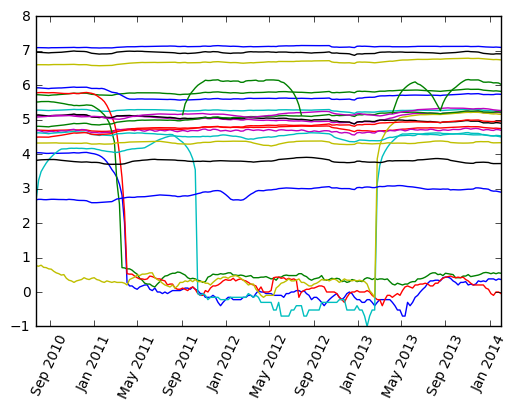

In [122]:
#plot test
pl.plot(weekinterval, np.log10(pd.stats.moments.rolling_mean(mta_allsum4,10)))
pl.xticks(rotation='65')

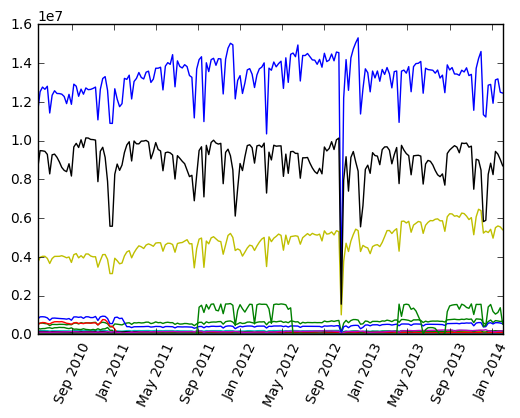

In [34]:
#plot test

pl.plot(weekinterval,(mta_allsum4))
pl.xticks(rotation='65')
pl.legend(loc='best')

In [77]:
cardtyperidesnozero = mta_allsum4[~((mta_allsum4 > 0))]
cardtyperidesnozero.shape

(304,)

In [78]:
#pl.plot(weekinterval,(pd.stats.moments.rolling_mean(cardtyperidesnozero,10)))

# Task 3

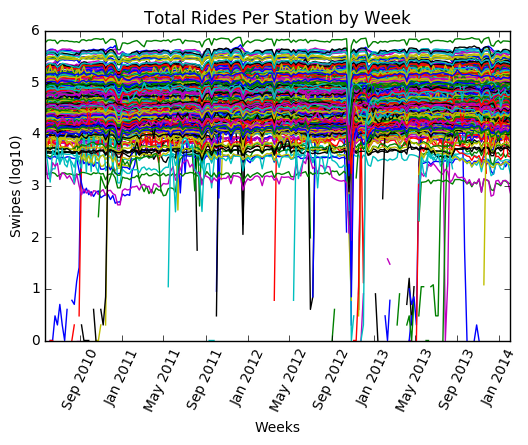

In [37]:
mtastationsum = mta_allsum2.transpose()
pl.plot(weekinterval, np.log10(mtastationsum))
pl.title('Total Rides Per Station by Week')
pl.xticks(rotation = '65')
pl.xlabel("Weeks")
pl.ylabel("Swipes (log10)")


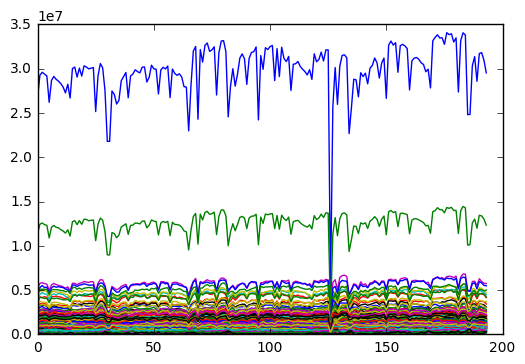

In [38]:
pl.plot(np.abs(np.fft.rfft(mtastationsum)))


In [39]:
N = 194 #the length of your time series (the number of datapoints) maybe is 194?
d = 1.0/52.0 #1 per every 52 weeks

np.fft.rfftfreq(N, d)

array([  0.        ,   0.26804124,   0.53608247,   0.80412371,
         1.07216495,   1.34020619,   1.60824742,   1.87628866,
         2.1443299 ,   2.41237113,   2.68041237,   2.94845361,
         3.21649485,   3.48453608,   3.75257732,   4.02061856,
         4.28865979,   4.55670103,   4.82474227,   5.09278351,
         5.36082474,   5.62886598,   5.89690722,   6.16494845,
         6.43298969,   6.70103093,   6.96907216,   7.2371134 ,
         7.50515464,   7.77319588,   8.04123711,   8.30927835,
         8.57731959,   8.84536082,   9.11340206,   9.3814433 ,
         9.64948454,   9.91752577,  10.18556701,  10.45360825,
        10.72164948,  10.98969072,  11.25773196,  11.5257732 ,
        11.79381443,  12.06185567,  12.32989691,  12.59793814,
        12.86597938,  13.13402062,  13.40206186,  13.67010309,
        13.93814433,  14.20618557,  14.4742268 ,  14.74226804,
        15.01030928,  15.27835052,  15.54639175,  15.81443299,
        16.08247423,  16.35051546,  16.6185567 ,  16.88

In [ ]:
meanstation = np.nanmean(mtaRides, axis=1)
meanstation.shape

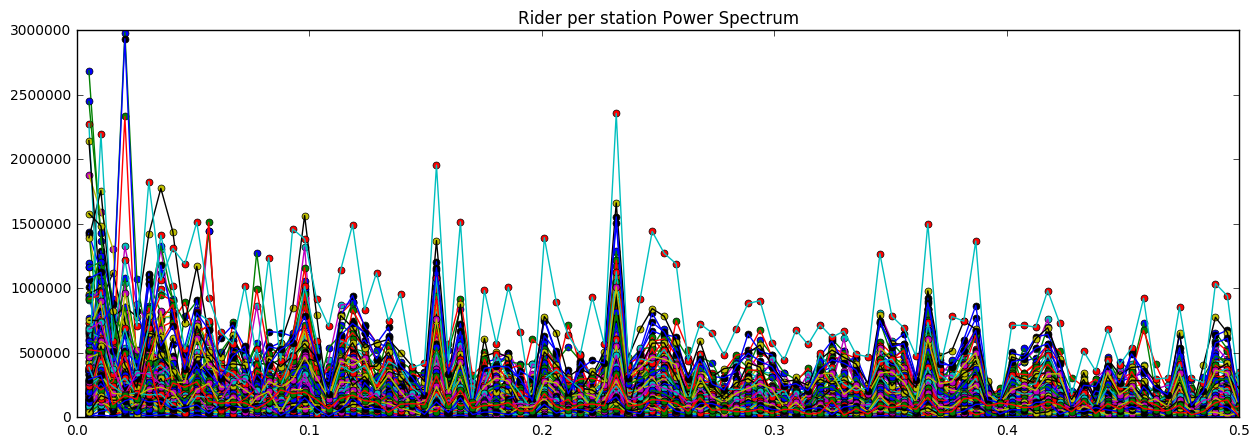

In [110]:
N = len(mtastationsum)
f = np.abs(np.fft.rfft(mta_allsum2))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

maxweeks = {}

for k in range(len(mtastationsum)):
    ax.plot(np.fft.rfftfreq(N, 1)[1:], (f[k][1:]),'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1)[1:], (f[k][1:]),'-')
    maxweeks[k]=((f[4]))

pl.title('Rider per station Power Spectrum')

    

In [70]:
f.shape

(600, 98)

In [119]:
len(maxweeks)

194

In [124]:
sorted_maxweeks = sorted(maxweeks.items(), key=operator.itemgetter(0))

In [129]:
(sorted_maxweeks)

[(0, array([ 3952084.        ,    21704.33227247,   159186.45629048,
            65954.31222146,    52457.802314  ,    40945.18517519,
            21021.07824856,    26563.28764897,    17431.54387873,
            18195.73902618,    85846.29075799,    44403.61725832,
            24838.55222462,    35096.36481727,    11221.85562897,
            44199.31833338,    23002.13051459,    17782.75435647,
            28614.23521769,    59265.9417499 ,     6303.23428175,
            21864.37357255,     7407.43715796,     6993.53381857,
            10601.30466244,    22767.29234414,    54085.23231043,
            49575.79960471,    44137.24012934,    28363.31073702,
            47717.18081171,    31035.421095  ,    35617.24927105,
            22446.45715392,    21697.47793904,    23231.7169099 ,
            27483.05070345,     7983.49896943,    18963.24633406,
            27852.45360353,    29653.90570382,    13990.22548593,
            12977.75183853,    14952.27173121,    12663.46396444,
       

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()